In [3]:
from dotenv import load_dotenv

load_dotenv("../config/.env")

True

In [4]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("deepseek-chat", model_provider="deepseek")

In [5]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///db/chinook/Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

### 以下是可预测的执行链

In [32]:
from typing_extensions import TypedDict, Annotated
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

class QueryOutput(TypedDict):
    """生成的 SQL 查询。"""
    query: Annotated[str, ..., "语法有效的 SQL 查询。"]

system_message = """
给定一个输入问题，创建一个语法正确的{dialect}查询来运行以帮助找到答案。除非用户在其问题中指定了他们希望获得的特定示例数量，否则始终将查询限制为最多{top_k}个结果。你可以按相关列对结果进行排序，以返回数据库中最有趣的示例。

切勿查询特定表中的所有列，只询问与问题相关的少数列。

注意只使用你在模式描述中能看到的列名。注意不要查询不存在的列。另外，注意哪些列在哪个表中。

仅使用以下表：
{table_info}
"""
user_prompt = "Qustion: {input}"
query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

def write_query(state: State):
    """生成用于获取信息的 SQL 查询。"""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

def execute_query(state: State):
    """执行 SQL 查询。"""
    excute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": excute_query_tool.invoke(state["query"])}

def generate_answer(state: State):
    """利用检索到的信息作为上下文来回答问题。"""
    prompt = (
        "鉴于以下用户问题、相应的 SQL 查询和 SQL 结果，请回答该用户问题。"
        f"问题: {state['question']}"
        f"SQL 查询: {state['query']}"
        f"SQL 查询结果: {state['result']}"
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence(
    [
        write_query,
        execute_query,
        generate_answer,
    ]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

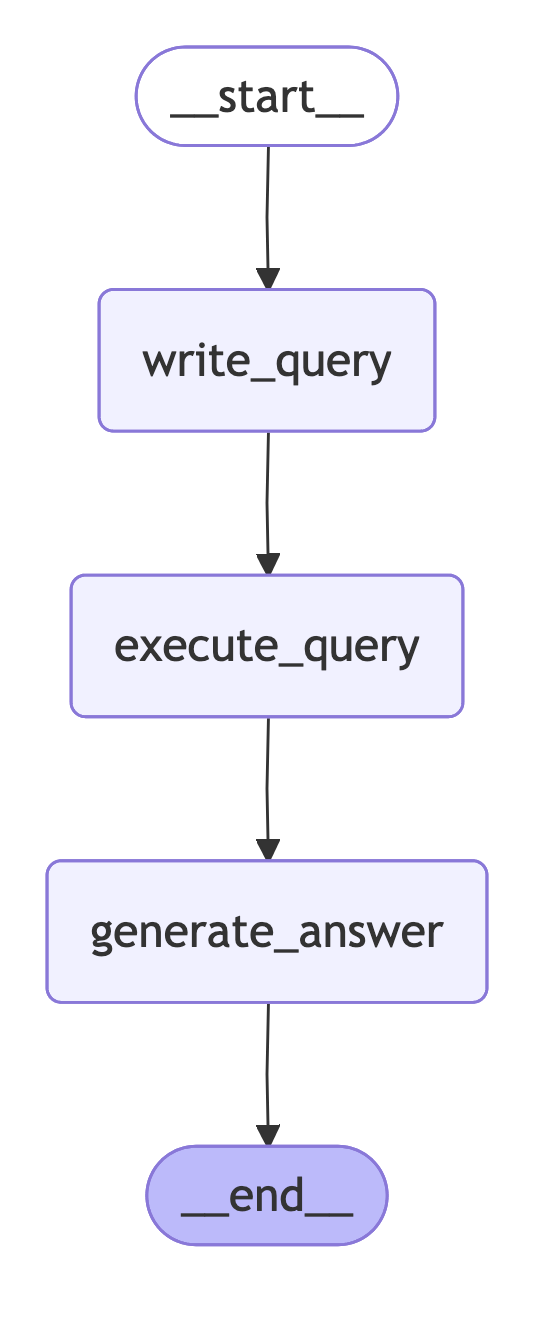

In [33]:
import nest_asyncio
from IPython.display import display, Image
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

nest_asyncio.apply()
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [28]:
for step in graph.stream(
    {"question": "有多少名员工？"},
    stream_mode="updates",
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) AS TotalEmployees FROM Employee;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': '根据查询结果，公司总共有 8 名员工。'}}


In [29]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

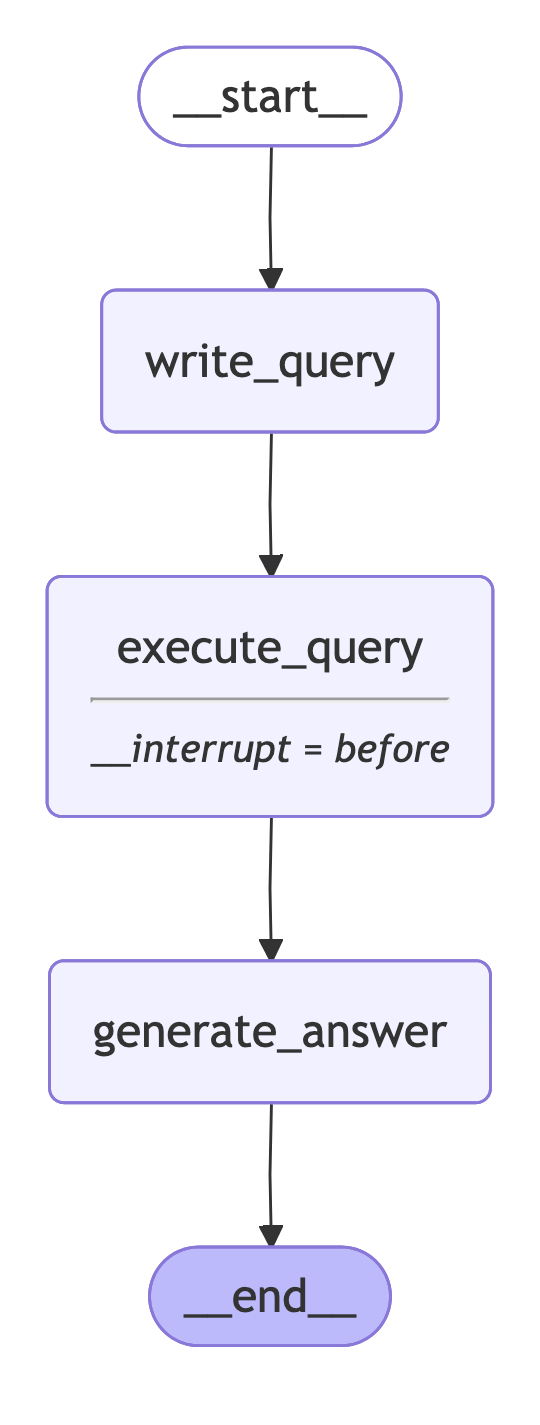

In [30]:
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [31]:
config = {"configurable": {"thread_id": "1"}}

for step in graph.stream(
    {"question": "有多少名员工？"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("你想执行查询吗? (yse/no):")
except:
    user_approval = "no"

if user_approval.lower() == "yes":
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("用户取消了操作。")

{'write_query': {'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee'}}
{'__interrupt__': ()}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': '根据查询结果，员工总数为 **8** 名。'}}


### 以下是 Agent 决策执行

In [34]:
from langgraph.prebuilt import create_react_agent
from langchain_community.agent_toolkits import SQLDatabaseToolkit

system_message = """
你是一个旨在与SQL数据库交互的代理。
给定一个输入问题，创建一个语法正确的{dialect}查询来运行，
然后查看查询结果并返回答案。除非用户指定了他们希望获得的特定示例数量，否则始终将查询限制为最多{top_k}个结果。
你可以按相关列对结果进行排序，以返回数据库中最有趣的示例。切勿查询特定表中的所有列，
只询问与问题相关的列。
在执行查询之前，你必须仔细检查查询。如果在执行查询时遇到错误，请重写查询并再次尝试。
不要对数据库执行任何DML语句（INSERT、UPDATE、DELETE、DROP等）。
开始时，你必须查看数据库中的表，了解可以查询的内容。不要跳过这一步。
然后，你应该查询最相关表的模式。
""".format(
    dialect=db.dialect,
    top_k=5,
)

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

agent_executor = create_react_agent(llm, tools, prompt=system_message)

In [36]:
question = "哪个国家的客户花费最多？"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

哪个国家的客户花费最多？
================================== Ai Message ==================================

我来帮您找出哪个国家的客户花费最多。首先，让我查看数据库中有哪些表。
Tool Calls:
  sql_db_list_tables (call_00_CAgn4lDJu9J9zjCCTEUyq68j)
 Call ID: call_00_CAgn4lDJu9J9zjCCTEUyq68j
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================

现在让我查看与客户和消费相关的表的结构，特别是Customer和Invoice表：
Tool Calls:
  sql_db_schema (call_00_jdHWjmETFhXn8ngfaME6O3be)
 Call ID: call_00_jdHWjmETFhXn8ngfaME6O3be
  Args:
    table_names: Customer, Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"Fir

In [37]:
question = "描述播放列表曲目表"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

描述播放列表曲目表
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_00_zZgypenvLVAK6fEiVpQkYFgJ)
 Call ID: call_00_zZgypenvLVAK6fEiVpQkYFgJ
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================

现在让我查看PlaylistTrack表的结构：
Tool Calls:
  sql_db_schema (call_00_QzyyWQCJeSTxJ1KPwePwGtXg)
 Call ID: call_00_QzyyWQCJeSTxJ1KPwePwGtXg
  Args:
    table_names: PlaylistTrack
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "PlaylistTrack" (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "T

In [40]:
import ast
import re

def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if sub]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))

artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")

print(artists[:5])
print(albums[:5])

['Aisha Duo', 'Titãs', 'Los Lonely Boys', 'Academy of St. Martin in the Fields Chamber Ensemble & Sir Neville Marriner', 'English Concert & Trevor Pinnock']
['In Step', '20th Century Masters - The Millennium Collection: The Best of Scorpions', 'Maquinarama', 'Barulhinho Bom', 'My Way: The Best Of Frank Sinatra [Disc ]']


In [41]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.agents.agent_toolkits import create_retriever_tool
from langchain_huggingface import HuggingFaceEmbeddings

description = (
    "用于查找要过滤的值。"
    "输入是专有名词的近似拼写，输出是有效的专有名词。"
    "使用与搜索内容最相似的名词"
)

subffix = (
    "如果你需要根据像姓名这样的专有名词进行筛选，"
    "你必须始终首先使用‘search_proper_nouns’工具查找筛选值！"
    "不要试图猜测专有名词 —— 使用这个函数来查找相似的名词。"
)
system = f"{system_message}\n\n{subffix}"

embeddings = HuggingFaceEmbeddings(model_name="Qwen/Qwen3-Embedding-0.6B")
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_texts(artists + albums)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description
)
tools.append(retriever_tool)
agent = create_react_agent(llm, tools, prompt=system)

In [42]:
question = "Alice Chains有多少张专辑"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Alice Chains有多少张专辑
================================== Ai Message ==================================

我来帮您查询Alice Chains的专辑数量。首先让我查看数据库中有哪些表。
Tool Calls:
  sql_db_list_tables (call_00_PFbJrN4HakmxMR0QEGe0N9IP)
 Call ID: call_00_PFbJrN4HakmxMR0QEGe0N9IP
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================

现在让我查看相关表的结构，特别是Artist和Album表：
Tool Calls:
  sql_db_schema (call_00_GbJJnxAvEOKm6bpgg4IBqV6X)
 Call ID: call_00_GbJJnxAvEOKm6bpgg4IBqV6X
  Args:
    table_names: Artist, Album
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCH